# Mount Google Drive
In this example, the data is saved in the folder of personal google drive.

First you have to upload the data to your google drive, then connect the drive.



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Packages

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
sns.set()
import matplotlib.pyplot as plt
plt.rcParams['ytick.labelsize'] = "x-large"
plt.rcParams['xtick.labelsize'] = "x-large"
plt.rcParams['axes.labelsize'] = "x-large"
plt.rcParams['figure.titlesize'] = "x-large"


from sklearn.preprocessing import normalize

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

from sklearn.metrics import mean_squared_error

# Data Description
C-MAPSS data set which contains turbofan engine degradation data is a widely used prognostic benchmark data for predicting the Remaining useful life (RUL). This data set is simulated by the tool Commercial Modular Aero Propulsion System Simulation (C-MAPSS) developed by NASA. Run to failure simulations were performed for engines with varying degrees of initial wear but in a healthy state. During each cycle in the simulation, one sample of all 21 sensors such as physical core speed, temperature at fan inlet and pressure at fan inlet etc will be recorded once. As the simulation progresses, the performance of the turbofan engine degrades until it loses functionality. 

C-MAPSS data consists of four sub-data sets with different operational conditions and fault patterns. 

|         Dataset        | FD001 | FD002 | FD003 | FD004 |
|:----------------------:|:-----:|:-----:|:-----:|:-----:|
|      Training set      |  100  |  260  |  100  |  249  |
|        Test set        |  100  |  259  |  100  |  248  |
| Operational conditions |   1   |   6   |   1   |   6   |
| Fault conditions       | 1     | 1     | 2     | 2     |


As shown Table above, each sub-data set has been split into a training set and a test set. The training sets contain sensor records for all cycles in the run to failure simulation. Unlike the training sets, the test sets only contain partial temporal sensor records which stopped at a time prior to the failure. The task is to predict the RUL of each engine in the test sets by using the training sets with the given sensor records. The corresponding RUL to test sets has been provided. With this, the performance of the model can be verified. 

The data provieded as text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

unit number

time, in cycles

operational setting 1

operational setting 2

operational setting 3

sensor measurement 1

sensor measurement 2 

sensor measurement 3 

...

sensor measurement 26

# Data Exploration and Preparation
take FD001 as example

In [7]:
# Load the Data
Path_to_data = "drive/My Drive/smartdata/1.9/" # if using google drive
#Path_to_data = "./Datasets/CMAPSSData" # if local - files not available in git repo

column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']
# training data set
train_FD001 = pd.read_table(Path_to_data+"train_FD001.txt", header=None, delim_whitespace=True)
train_FD001.columns = column_name

# test data set
test_FD001 = pd.read_table(Path_to_data+"test_FD001.txt", header=None, delim_whitespace=True)
test_FD001.columns = column_name

# RUL for test data set
RUL_FD001 = pd.read_table(Path_to_data+"RUL_FD001.txt", header=None, delim_whitespace=True)

train_FD001.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In this sub dataset we have **100** engines (engine_id) which are monitored over time (cycle). Each engine had operational_settings and sensor_measurements recorded for each cycle. The RUL is the amount of cycles an engine has left before it needs maintenance. What makes this data set special is that the engines run all the way until failure, giving us precise RUL information for every engine at every point in time.

In [8]:
def add_RUL(col):
    max_cycle = col.max()
    col = max_cycle-col

    return col
# Calculate RUL for each time point of each engine  
train_FD001['rul'] = train_FD001[['engine_id', 'cycle']].groupby('engine_id').transform(add_RUL)
test_FD001['rul'] = test_FD001[['engine_id', 'cycle']].groupby('engine_id').transform(add_RUL)

In [9]:
train_FD001

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


**Is there any other way to define target lable (RUL) ?** 

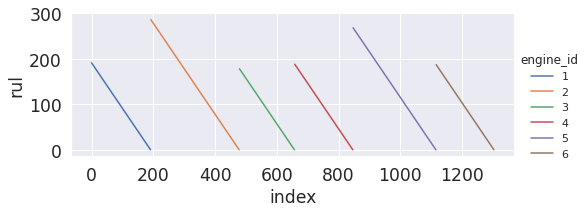

In [10]:
# Visualize the RUL curve of some engines (1,2,3,4,5,6)
g = sns.PairGrid(data=train_FD001.reset_index().query('engine_id < 7') ,
                 x_vars=["index"],
                 y_vars=['rul'],
                 hue="engine_id", height=3, aspect=2.5)

g = g.map(plt.plot, alpha=1)
g = g.add_legend()

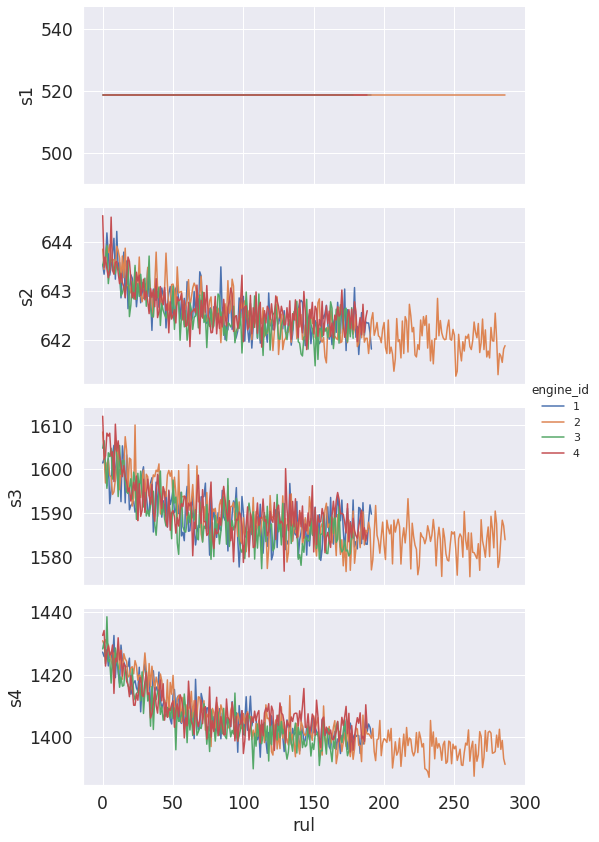

In [11]:
# Visualize some sensor curves of some engines 
g = sns.PairGrid(data=train_FD001.query('engine_id < 5') ,
                 x_vars=["rul"],
                 y_vars=['s1','s2','s3','s4'],
                 hue="engine_id", height=3, aspect=2.5)

g = g.map(plt.plot, alpha=1)
g = g.add_legend()

# As shown in the figure, some sensors are not related to RUL. 
# The values of some sensors change with the state of the machine. 
# Visualization can help filter features

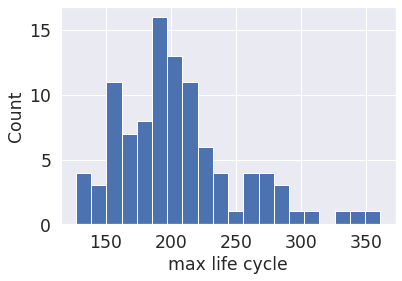

In [12]:
# Distribution of maximum life cycle
train_FD001[['engine_id', 'rul']].groupby('engine_id').apply(np.max)["rul"].hist(bins=20)
plt.xlabel("max life cycle")
plt.ylabel("Count")
plt.show()

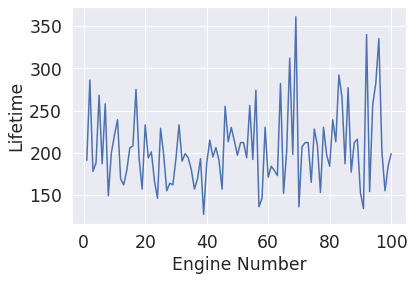

In [13]:
#Lifetime of every engine, assuming the data (engines) is in sequential order
plt.plot(train_FD001[['engine_id', 'rul']].groupby('engine_id').apply(np.max)["rul"])
plt.xlabel("Engine Number")
plt.ylabel("Lifetime")
plt.show()

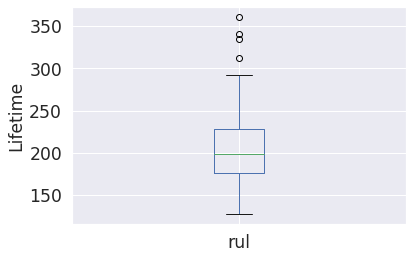

In [14]:
# Box Plot, showing Median, Quartiles, Whiskers

train_FD001[['engine_id', 'rul']].groupby('engine_id').apply(np.max)['rul'].plot(kind='box')
plt.ylabel("Lifetime")
plt.xlabel("")
plt.show()

In [15]:
#Average Life Cycle
np.average(train_FD001[['engine_id', 'rul']].groupby('engine_id').apply(np.max)["rul"])

205.31

In [16]:
# prepare the data and normalization
train_y = train_FD001['rul']
features = train_FD001.columns.drop(['engine_id', 'cycle', 'rul'])
train_x = train_FD001[features]
test_x = test_FD001[features]
test_y = test_FD001['rul']


# z score normalization
mean = train_x.mean()
std = train_x.std()
std.replace(0, 1, inplace=True)

train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

from sklearn.utils import shuffle
x, y = shuffle(train_x, train_y)



# Modeling

## Single Datapoint Only

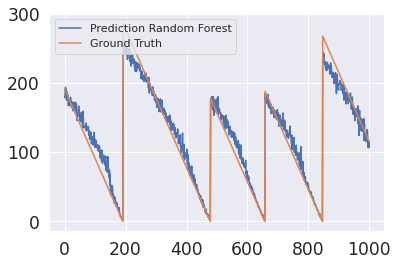

In [17]:
# Random Forest with default Hyper parameters
rf_model = RandomForestRegressor()
rf_model.fit(x,y)
rf_prediction = rf_model.predict(train_x)
plt.plot(rf_prediction[:1000])
plt.plot(train_FD001["rul"][:1000])
plt.legend(['Prediction Random Forest','Ground Truth'], loc='upper left')
plt.show()

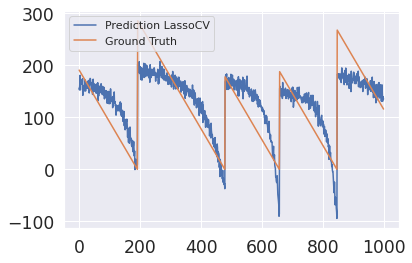

In [18]:
# Lasso model with default Hyper parameters
ls_model = LassoCV(normalize=False)
ls_model.fit(x,y)
ls_prediction = ls_model.predict(train_x)
plt.plot(ls_prediction[:1000])
plt.plot(train_FD001["rul"][:1000])
plt.legend(['Prediction LassoCV','Ground Truth'], loc='upper left')
plt.show()

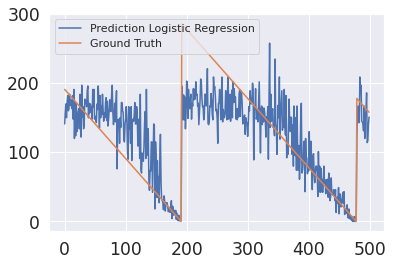

In [19]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
lg_model = LogisticRegression(solver='liblinear')
lg_model.fit(x,y)
lg_prediction = lg_model.predict(train_x)
plt.plot(lg_prediction[:500])
plt.plot(train_FD001["rul"][:500])
plt.legend(['Prediction Logistic Regression','Ground Truth'], loc='upper left')
plt.show()

**How to tune hyperparameters and select models?** 

Hyperparameters can be tuned using Cross Validation - for example model_selection from sklearn library.

Example using Grid Search:
```python
import GridSearchCV from sklearn.model_selection
tuned_parameters = {'n_estimators': [500, 700, 1000], 'max_depth': [None, 1, 2, 3], 'min_samples_split': [1, 2, 3]}
gridsearch = GridSearchCV(rf_model, tuned_parameters, cv=5, n_jobs=-1, verbose=1)
gridsearch.fit(x,y)
```



In [20]:
from keras.layers import Input, Dense,Conv2D, Dropout
from keras.models import Model

input_dimension = len(features)
output_nodes = 1

model_input = Input(shape=(input_dimension,), name="Input")
hidden_layer = Dropout(.2, input_shape=(input_dimension,))(model_input)
hidden_layer = Dense(12, activation='gelu', name="Hidden1")(hidden_layer)
hidden_layer = Dropout(.2, input_shape=(12,))(hidden_layer)
hidden_layer = Dense(6, activation='gelu', name="Hidden2")(hidden_layer)
hidden_layer = Dropout(.2, input_shape=(6,))(hidden_layer)
hidden_layer = Dense(3, activation='gelu', name="Hidden3")(hidden_layer)
hidden_layer = Dropout(.2, input_shape=(3,))(hidden_layer)
model_output = Dense(1, activation='gelu', name="Output")(hidden_layer)

model = Model(model_input, model_output)

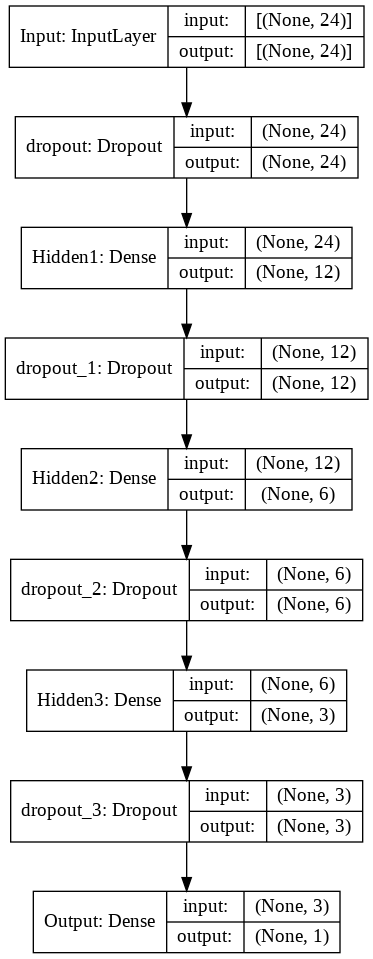

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [22]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model.compile(optimizer='adam',loss='mse', metrics=['mse',root_mean_squared_error,'binary_crossentropy'])
yfloat = y.astype(float)
y_test_float = test_y.astype(float)
history = model.fit(x,yfloat,
                    epochs=40,
                    batch_size=256,
                    validation_data=(test_x,y_test_float))

Epoch 1/40
81/81 [==============================] - 2s 9ms/step - loss: 16183.1844 - mse: 16183.1844 - root_mean_squared_error: 127.1296 - binary_crossentropy: 482.1012 - val_loss: 8226.7510 - val_mse: 8226.7510 - val_root_mean_squared_error: 86.1480 - val_binary_crossentropy: -982.4352
Epoch 2/40
81/81 [==============================] - 0s 3ms/step - loss: 15452.1403 - mse: 15452.1403 - root_mean_squared_error: 124.2177 - binary_crossentropy: -1198.3044 - val_loss: 5889.5581 - val_mse: 5889.5581 - val_root_mean_squared_error: 72.0215 - val_binary_crossentropy: -1141.1486
Epoch 3/40
81/81 [==============================] - 0s 3ms/step - loss: 11278.6652 - mse: 11278.6652 - root_mean_squared_error: 105.8972 - binary_crossentropy: -1527.3578 - val_loss: 2440.3167 - val_mse: 2440.3167 - val_root_mean_squared_error: 46.1749 - val_binary_crossentropy: -1141.1996
Epoch 4/40
81/81 [==============================] - 0s 3ms/step - loss: 6027.3515 - mse: 6027.3515 - root_mean_squared_error: 77.4

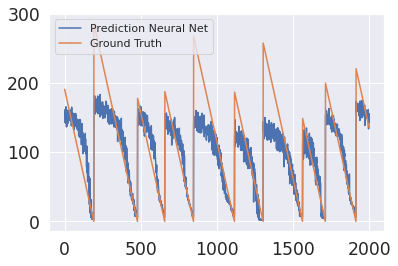

In [23]:
dl_prediction = model.predict(train_x)
plt.plot(dl_prediction[:2000])
plt.plot(train_FD001["rul"][:2000])
plt.legend(['Prediction Neural Net','Ground Truth'], loc='upper left')
plt.show()

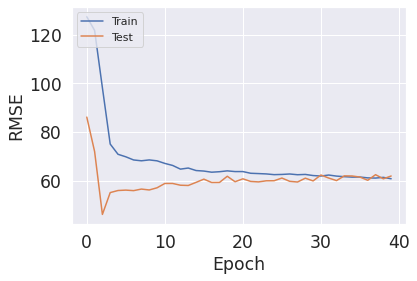

In [24]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

## Sliding Window

In [25]:
def sliding_window(df_in, k):
    df_out = df_in.copy() 
    df_master_copy = df_in.copy()

    # enumerate engines
    for i in reversed(range(k - 1)):
        df_copy = df_master_copy.copy()

        to_delete = k - i - 1
        
        # Delete last x rows in the local copy
        df_copy = df_copy[:-to_delete]

        # Insert x empty rows at the beginning
        for j in range(to_delete):
            df_copy = df_copy.append(pd.Series(name='0', dtype='float64'))
            df_copy = df_copy.shift(periods=1)
            df_copy = df_copy.reset_index(drop=True)

        # Replace NaN values with zero
        df_copy = df_copy.fillna(0)
        
        # Rename columns: Use original name and add ...-tminusX
        new_cols = []
        for col_orig in df_copy.columns:
            new_cols.append(col_orig + "-tminus" + str(to_delete))

        df_copy.columns = new_cols

        # Append columns to result data frame
        df_out = df_copy.join(df_out)

    return df_out

In [26]:
train_x_sliding = sliding_window(train_x,10)
test_x_sliding = sliding_window(test_x,10)
x_sliding,y_sliding = shuffle(train_x_sliding, train_y)

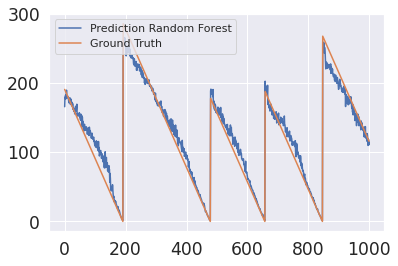

In [27]:
# Random Forest with default Hyper parameters
rf_model_sliding = RandomForestRegressor()
rf_model_sliding.fit(x_sliding,y_sliding)
rf_prediction_sliding = rf_model_sliding.predict(train_x_sliding)
plt.plot(rf_prediction_sliding[:1000])
plt.plot(train_FD001["rul"][:1000])
plt.legend(['Prediction Random Forest','Ground Truth'], loc='upper left')
plt.show()

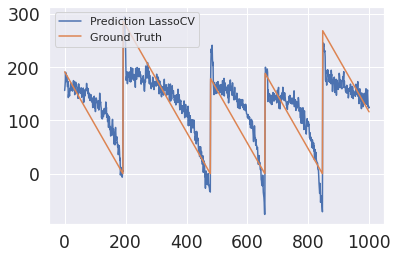

In [28]:
# Lasso model with default Hyper parameters
ls_model_sliding = LassoCV(normalize=False)
ls_model_sliding.fit(x_sliding,y_sliding)
ls_prediction_sliding = ls_model_sliding.predict(train_x_sliding)
plt.plot(ls_prediction_sliding[:1000])
plt.plot(train_FD001["rul"][:1000])
plt.legend(['Prediction LassoCV','Ground Truth'], loc='upper left')
plt.show()

In [29]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
lg_model_sliding = LogisticRegression(solver='liblinear')
lg_model_sliding.fit(x_sliding,y_sliding)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

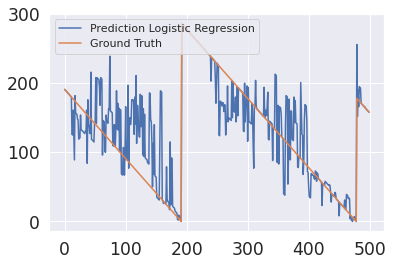

In [30]:
lg_prediction_sliding = lg_model_sliding.predict(train_x_sliding)
plt.plot(lg_prediction_sliding[:500])
plt.plot(train_FD001["rul"][:500])
plt.legend(['Prediction Logistic Regression','Ground Truth'], loc='upper left')
plt.show()

In [31]:
input_dimension_sliding = len(features)*10
output_nodes = 1

model_input_sliding = Input(shape=(input_dimension_sliding,), name="Input")
hidden_layer = Dropout(.2, input_shape=(input_dimension_sliding,))(model_input_sliding)
hidden_layer = Dense(60, activation='gelu', name="Hidden1")(hidden_layer)
hidden_layer = Dropout(.2, input_shape=(12,))(hidden_layer)
hidden_layer = Dense(9, activation='gelu', name="Hidden2")(hidden_layer)
hidden_layer = Dropout(.2, input_shape=(6,))(hidden_layer)
hidden_layer = Dense(3, activation='gelu', name="Hidden3")(hidden_layer)
hidden_layer = Dropout(.2, input_shape=(3,))(hidden_layer)
model_output_sliding = Dense(1, activation='gelu', name="Output")(hidden_layer)

model_sliding = Model(model_input_sliding, model_output_sliding)

In [34]:
model_sliding.compile(optimizer='adam',loss='mse', metrics=['mse',root_mean_squared_error,'binary_crossentropy'])
yfloat_sliding = y_sliding.astype(float)
y_test_float = test_y.astype(float)
history_sliding = model_sliding.fit(x_sliding,yfloat_sliding,
                    epochs=40,
                    batch_size=256,
                    validation_data=(test_x_sliding,y_test_float))

Epoch 1/40
81/81 [==============================] - 2s 11ms/step - loss: 16356.8514 - mse: 16356.8514 - root_mean_squared_error: 127.8361 - binary_crossentropy: 418.0103 - val_loss: 8533.6533 - val_mse: 8533.6533 - val_root_mean_squared_error: 87.8276 - val_binary_crossentropy: 98.9197
Epoch 2/40
81/81 [==============================] - 1s 6ms/step - loss: 16249.0514 - mse: 16249.0514 - root_mean_squared_error: 127.4067 - binary_crossentropy: 139.5112 - val_loss: 8515.3896 - val_mse: 8515.3896 - val_root_mean_squared_error: 87.7250 - val_binary_crossentropy: 52.4156
Epoch 3/40
81/81 [==============================] - 1s 6ms/step - loss: 16334.2555 - mse: 16334.2555 - root_mean_squared_error: 127.7646 - binary_crossentropy: 67.8976 - val_loss: 8495.2256 - val_mse: 8495.2256 - val_root_mean_squared_error: 87.6117 - val_binary_crossentropy: 10.1542
Epoch 4/40
81/81 [==============================] - 1s 7ms/step - loss: 16176.1231 - mse: 16176.1231 - root_mean_squared_error: 127.1146 - bin

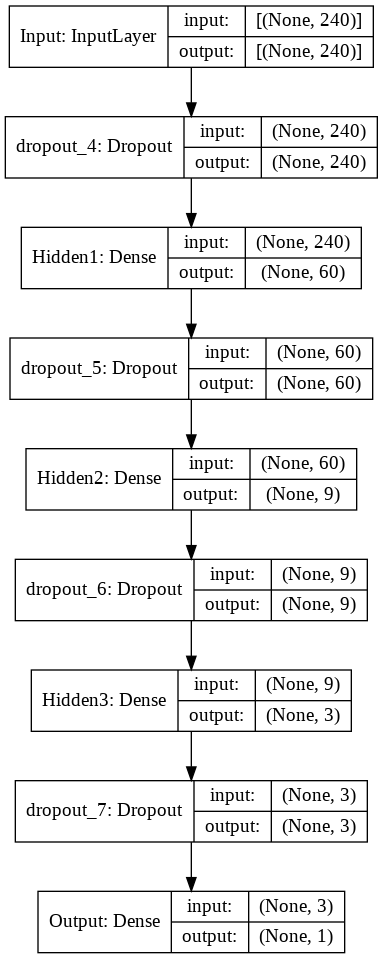

In [42]:
plot_model(model_sliding, show_shapes=True)

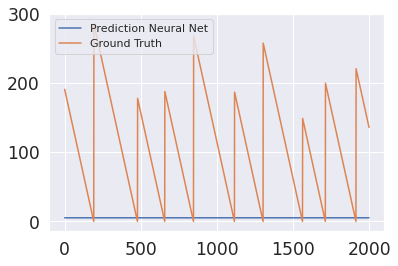

In [35]:
dl_prediction_sliding = model_sliding.predict(train_x_sliding)
plt.plot(dl_prediction_sliding[:2000])
plt.plot(train_FD001["rul"][:2000])
plt.legend(['Prediction Neural Net','Ground Truth'], loc='upper left')
plt.show()

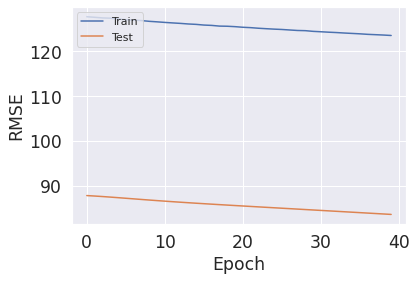

In [36]:
plt.plot(history_sliding.history['root_mean_squared_error'])
plt.plot(history_sliding.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

# Evaluation

In [37]:

# Since only the value at one time point is used, it can be seen that a lot of data in the test set is not used

test_x['engine_id'] = test_FD001['engine_id']
test_x_sliding['engine_id'] = test_FD001['engine_id']
test_input = []
test_input_sliding = []
for id in test_x['engine_id'].unique():
  test_input.append(test_x[test_x['engine_id']==id].iloc[-1,:-1].values)
for id in test_x_sliding['engine_id'].unique():
  test_input_sliding.append(test_x_sliding[test_x_sliding['engine_id']==id].iloc[-1,:-1].values)

In [38]:
# Random forest
rf_test_prediction = rf_model.predict(test_input)

rf_rmse = np.sqrt(mean_squared_error(rf_test_prediction, RUL_FD001.values.reshape(-1)))

rf_test_prediction_sliding = rf_model_sliding.predict(test_input_sliding)

rf_rmse_sliding = np.sqrt(mean_squared_error(rf_test_prediction_sliding, RUL_FD001.values.reshape(-1)))
print("The RMSE of random forest on test dataset FD001 is ",rf_rmse)
print("The RMSE of random forest on test dataset FD001 with a sliding Window is ", rf_rmse_sliding)



The RMSE of random forest on test dataset FD001 is  33.18621212190388
The RMSE of random forest on test dataset FD001 with a sliding Window is  32.8503195266043


In [39]:
# Lasso model

ls_test_prediction = ls_model.predict(test_input)

ls_rmse = np.sqrt(mean_squared_error(ls_test_prediction, RUL_FD001.values.reshape(-1)))

ls_test_prediction_sliding = ls_model_sliding.predict(test_input_sliding)

ls_rmse_sliding = np.sqrt(mean_squared_error(ls_test_prediction_sliding, RUL_FD001.values.reshape(-1)))

print("The RMSE of Lasso model on test dataset FD001 is ",ls_rmse)
print("The RMSE of Lasso model on test dataset FD001 with a sliding Window is ", ls_rmse_sliding)

The RMSE of Lasso model on test dataset FD001 is  32.02470917500612
The RMSE of Lasso model on test dataset FD001 with a sliding Window is  30.32434033314536


In [40]:
# Logistic Regression

lg_test_prediction = lg_model.predict(test_input)

lg_rmse = np.sqrt(mean_squared_error(lg_test_prediction, RUL_FD001.values.reshape(-1)))

lg_test_prediction_sliding = lg_model_sliding.predict(test_input_sliding)

lg_rmse_sliding = np.sqrt(mean_squared_error(lg_test_prediction_sliding, RUL_FD001.values.reshape(-1)))

print("The RMSE of Logistic Regression on test dataset FD001 is ",lg_rmse)
print("The RMSE of Logistic Regression on test dataset FD001 with a sliding Window is ", lg_rmse_sliding)

The RMSE of Logistic Regression on test dataset FD001 is  32.35042503584767
The RMSE of Logistic Regression on test dataset FD001 with a sliding Window is  56.819538892884374


In [41]:
# Deep Learning

dl_test_prediction = model.predict(pd.DataFrame(test_input))

dl_rmse = np.sqrt(mean_squared_error(dl_test_prediction, RUL_FD001.values.reshape(-1)))

dl_test_prediction_sliding = model_sliding.predict(pd.DataFrame(test_input_sliding))

dl_rmse_sliding = np.sqrt(mean_squared_error(dl_test_prediction_sliding, RUL_FD001.values.reshape(-1)))

print("The RMSE of the Neural Net on test dataset FD001 is ",dl_rmse)
print("The RMSE of the Neural Net on test dataset FD001 with a sliding Window is ", dl_rmse_sliding)

The RMSE of the Neural Net on test dataset FD001 is  21.82801548717743
The RMSE of the Neural Net on test dataset FD001 with a sliding Window is  81.65564465411214


# Conclusion

Our best result was the neural net without a sliding Window.
In our experiments, the sliding window approach resulted in better results with random forest and lasso models.
With logistic regression and a neural net we got worse results.

Of course this does not have to be the norm, especially since hyperparameter haven't been optimized.

**What is your best result? If the used model is interpretable, what other conclusions can be summarized**